# A Comparison of Machine Learning Algorithms on Facial Recognition

*by Markus Dabell, Dec 13, 2021* 

In [2]:
import numpy as np
from numpy import asarray

from sklearn import decomposition, svm, metrics, datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
from torch.autograd import Variable

import pandas as pd
pd.set_option('display.max_rows', None) 

import matplotlib.pyplot as plt

from PIL import Image

from math import sqrt

import neuralnetworks as nn
import neuralnetworkscnn as cnn

import time

I gathered 10 images from 11 different people (including myself) to use as data.

In [3]:
num_of_unique_images = 11

I defined a couple different functions. 

import_and_prepare_picture_as_greyed_out: takes an image (I scaled all the images to be 64x64 pixels), makes it gray, puts the pixel values between 0 and 1, and makes an array out of a picture.

plot_images: shows an image from an array of pixels

perform_pca_on_a_persons_images: performs Principle Component Analysis on a picture to get it from 64x64 = 4096 pixels to a smaller dimension (I used 8x8 = 64 features when I applied PCA).

plot_pca_of_image: plots the image's Principal Components after applying PCA to the image.

convert_data_to_pca_data: I followed a tutorial on how to do PCA with sklearn, and by using their library you get an object of type "sklearn.decomposition.(underscore)pca.PCA" that you have to transform to use the PCA'd features

make_target_set_for_a_number_of_unique_images: this function makes a generic target set. (10 1's, 10 2's, 10 3's, etc.)

percent_correct: used to compare the output with the test output to give an accuracy

confusion_matrix: used to compare the output with the test output to create a confusion matrix

In [4]:
def import_and_prepare_picture_as_greyed_out(jpg, rotate=False):
    
    image = Image.open(jpg) #opens image
    
    if (rotate):
        image_rotated = image.rotate(-90) #rotate the image
        pixels_as_array = asarray(image_rotated) #turns it to a np array

    else:
        pixels_as_array = asarray(image)
        
    pixels_as_array = pixels_as_array.astype('float32') #changes type of pixels
    pixels_as_array /= 255.0 #get pixels between 0 and 1
    pixels_as_array = pixels_as_array[:,:,0] #make it grey scale by taking off the third column describing color
    pixels_as_array = pixels_as_array.reshape(1, -1) 

    return pixels_as_array

In [5]:
def plot_images(array_of_pixels_for_an_image):
    
    num_of_pictures = array_of_pixels_for_an_image.shape[0]
    fig = plt.figure(figsize=(15, 5))
    for i in range(num_of_pictures):
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(array_of_pixels_for_an_image[i].reshape(64, 64), cmap=plt.cm.bone)

In [6]:
def perform_pca_on_a_persons_images(all_images_in_one_array, n_components):
    
    pca_of_image = decomposition.PCA(n_components=n_components, whiten=True) #prep the pca... can change the n_components
    pca_of_image.fit(all_images_in_one_array) #fit the images to the pca
    return pca_of_image

In [7]:
def plot_pca_of_image(pca_of_image):
        plt.imshow(pca_of_image.mean_.reshape(64, 64), cmap=plt.cm.bone)

In [8]:
def convert_data_to_pca_data(data, pca):
    pca_data = pca.transform(data)
    return pca_data

In [9]:
#currently only works with 10 images of each person
def make_target_set_for_a_number_of_unique_images(number_of_unique_images):
    target_set = np.zeros(number_of_unique_images * 10)
    j=0
    k=0
    for i in range(number_of_unique_images):
        target_set[j:j+10] = k
        j+=10
        k+=1
    return target_set.reshape(-1,1)

In [10]:
def percent_correct(Y, T):
    return np.mean(T == Y) * 100

In [11]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix.style.background_gradient(cmap='Greens').format("{:.1f}")

# Data

In [12]:
markus1 = import_and_prepare_picture_as_greyed_out('markus1.jpg', True)
markus2 = import_and_prepare_picture_as_greyed_out('markus2.jpg', True)
markus3 = import_and_prepare_picture_as_greyed_out('markus3.jpg', True)
markus4 = import_and_prepare_picture_as_greyed_out('markus4.jpg', True)
markus5 = import_and_prepare_picture_as_greyed_out('markus5.jpg', True)
markus6 = import_and_prepare_picture_as_greyed_out('markus6.jpg', True)
markus7 = import_and_prepare_picture_as_greyed_out('markus7.jpg', True)
markus8 = import_and_prepare_picture_as_greyed_out('markus8.jpg', True)
markus9 = import_and_prepare_picture_as_greyed_out('markus9.jpg', True)
markus10 = import_and_prepare_picture_as_greyed_out('markus10.jpg', True)


markusimages = np.vstack((markus1, markus2, markus3, markus4, 
                                    markus5, markus6, markus7, markus8, 
                                    markus9, markus10))
markusimages.shape

(10, 4096)

In [13]:
mom1 = import_and_prepare_picture_as_greyed_out('mom1.jpg')
mom2 = import_and_prepare_picture_as_greyed_out('mom2.jpg')
mom3 = import_and_prepare_picture_as_greyed_out('mom3.jpg')
mom4 = import_and_prepare_picture_as_greyed_out('mom4.jpg')
mom5 = import_and_prepare_picture_as_greyed_out('mom5.jpg')
mom6 = import_and_prepare_picture_as_greyed_out('mom6.jpg')
mom7 = import_and_prepare_picture_as_greyed_out('mom7.jpg')
mom8 = import_and_prepare_picture_as_greyed_out('mom8.jpg')
mom9 = import_and_prepare_picture_as_greyed_out('mom9.jpg')
mom10 = import_and_prepare_picture_as_greyed_out('mom10.jpg')


momimages = np.vstack((mom1, mom2, mom3, mom4, 
                                    mom5, mom6, mom7, mom8, 
                                    mom9, mom10))
momimages.shape

(10, 4096)

In [14]:
arnie1 = import_and_prepare_picture_as_greyed_out('arnie1.jpg')
arnie2 = import_and_prepare_picture_as_greyed_out('arnie2.jpg')
arnie3 = import_and_prepare_picture_as_greyed_out('arnie3.jpg')
arnie4 = import_and_prepare_picture_as_greyed_out('arnie4.jpg')
arnie5 = import_and_prepare_picture_as_greyed_out('arnie5.jpg')
arnie6 = import_and_prepare_picture_as_greyed_out('arnie6.jpg')
arnie7 = import_and_prepare_picture_as_greyed_out('arnie7.jpg')
arnie8 = import_and_prepare_picture_as_greyed_out('arnie8.jpg')
arnie9 = import_and_prepare_picture_as_greyed_out('arnie9.jpg')
arnie10 = import_and_prepare_picture_as_greyed_out('arnie10.jpg')


arnieimages = np.vstack((arnie1, arnie2, arnie3, arnie4, 
                                    arnie5, arnie6, arnie7, arnie8, 
                                    arnie9, arnie10))
arnieimages.shape

(10, 4096)

In [15]:
bryan1 = import_and_prepare_picture_as_greyed_out('bryan1.jpg')
bryan2 = import_and_prepare_picture_as_greyed_out('bryan2.jpg')
bryan3 = import_and_prepare_picture_as_greyed_out('bryan3.jpg')
bryan4 = import_and_prepare_picture_as_greyed_out('bryan4.jpg')
bryan5 = import_and_prepare_picture_as_greyed_out('bryan5.jpg')
bryan6 = import_and_prepare_picture_as_greyed_out('bryan6.jpg')
bryan7 = import_and_prepare_picture_as_greyed_out('bryan7.jpg')
bryan8 = import_and_prepare_picture_as_greyed_out('bryan8.jpg')
bryan9 = import_and_prepare_picture_as_greyed_out('bryan9.jpg')
bryan10 = import_and_prepare_picture_as_greyed_out('bryan10.jpg')


bryanimages = np.vstack((bryan1, bryan2, bryan3, bryan4, 
                                    bryan5, bryan6, bryan7, bryan8, 
                                    bryan9, bryan10))
bryanimages.shape

(10, 4096)

In [16]:
beccar1 = import_and_prepare_picture_as_greyed_out('beccar1.jpg')
beccar2 = import_and_prepare_picture_as_greyed_out('beccar2.jpg')
beccar3 = import_and_prepare_picture_as_greyed_out('beccar3.jpg')
beccar4 = import_and_prepare_picture_as_greyed_out('beccar4.jpg')
beccar5 = import_and_prepare_picture_as_greyed_out('beccar5.jpg')
beccar6 = import_and_prepare_picture_as_greyed_out('beccar6.jpg')
beccar7 = import_and_prepare_picture_as_greyed_out('beccar7.jpg')
beccar8 = import_and_prepare_picture_as_greyed_out('beccar8.jpg')
beccar9 = import_and_prepare_picture_as_greyed_out('beccar9.jpg')
beccar10 = import_and_prepare_picture_as_greyed_out('beccar10.jpg')


beccarimages = np.vstack((beccar1, beccar2, beccar3, beccar4, 
                                    beccar5, beccar6, beccar7, beccar8, 
                                    beccar9, beccar10))
beccarimages.shape

(10, 4096)

In [17]:
beccad1 = import_and_prepare_picture_as_greyed_out('beccad1.jpg')
beccad2 = import_and_prepare_picture_as_greyed_out('beccad2.jpg')
beccad3 = import_and_prepare_picture_as_greyed_out('beccad3.jpg')
beccad4 = import_and_prepare_picture_as_greyed_out('beccad4.jpg')
beccad5 = import_and_prepare_picture_as_greyed_out('beccad5.jpg')
beccad6 = import_and_prepare_picture_as_greyed_out('beccad6.jpg')
beccad7 = import_and_prepare_picture_as_greyed_out('beccad7.jpg')
beccad8 = import_and_prepare_picture_as_greyed_out('beccad8.jpg')
beccad9 = import_and_prepare_picture_as_greyed_out('beccad9.jpg')
beccad10 = import_and_prepare_picture_as_greyed_out('beccad10.jpg')


beccadimages = np.vstack((beccad1, beccad2, beccad3, beccad4, 
                                    beccad5, beccad6, beccad7, beccad8, 
                                    beccad9, beccad10))
beccadimages.shape

(10, 4096)

In [18]:
david1 = import_and_prepare_picture_as_greyed_out('david1.jpg')
david2 = import_and_prepare_picture_as_greyed_out('david2.jpg')
david3 = import_and_prepare_picture_as_greyed_out('david3.jpg')
david4 = import_and_prepare_picture_as_greyed_out('david4.jpg')
david5 = import_and_prepare_picture_as_greyed_out('david5.jpg')
david6 = import_and_prepare_picture_as_greyed_out('david6.jpg')
david7 = import_and_prepare_picture_as_greyed_out('david7.jpg')
david8 = import_and_prepare_picture_as_greyed_out('david8.jpg')
david9 = import_and_prepare_picture_as_greyed_out('david9.jpg')
david10 = import_and_prepare_picture_as_greyed_out('david10.jpg')


davidimages = np.vstack((david1, david2, david3, david4, 
                                    david5, david6, david7, david8, 
                                    david9, david10))
davidimages.shape

(10, 4096)

In [19]:
whitney1 = import_and_prepare_picture_as_greyed_out('whitney1.jpg')
whitney2 = import_and_prepare_picture_as_greyed_out('whitney2.jpg')
whitney3 = import_and_prepare_picture_as_greyed_out('whitney3.jpg')
whitney4 = import_and_prepare_picture_as_greyed_out('whitney4.jpg')
whitney5 = import_and_prepare_picture_as_greyed_out('whitney5.jpg')
whitney6 = import_and_prepare_picture_as_greyed_out('whitney6.jpg')
whitney7 = import_and_prepare_picture_as_greyed_out('whitney7.jpg')
whitney8 = import_and_prepare_picture_as_greyed_out('whitney8.jpg')
whitney9 = import_and_prepare_picture_as_greyed_out('whitney9.jpg')
whitney10 = import_and_prepare_picture_as_greyed_out('whitney10.jpg')


whitneyimages = np.vstack((whitney1, whitney2, whitney3, whitney4, 
                                    whitney5, whitney6, whitney7, whitney8, 
                                    whitney9, whitney10))
whitneyimages.shape

(10, 4096)

In [20]:
aarim1 = import_and_prepare_picture_as_greyed_out('aarim1.jpg')
aarim2 = import_and_prepare_picture_as_greyed_out('aarim2.jpg')
aarim3 = import_and_prepare_picture_as_greyed_out('aarim3.jpg')
aarim4 = import_and_prepare_picture_as_greyed_out('aarim4.jpg')
aarim5 = import_and_prepare_picture_as_greyed_out('aarim5.jpg')
aarim6 = import_and_prepare_picture_as_greyed_out('aarim6.jpg')
aarim7 = import_and_prepare_picture_as_greyed_out('aarim7.jpg')
aarim8 = import_and_prepare_picture_as_greyed_out('aarim8.jpg')
aarim9 = import_and_prepare_picture_as_greyed_out('aarim9.jpg')
aarim10 = import_and_prepare_picture_as_greyed_out('aarim10.jpg')


aarimimages = np.vstack((aarim1, aarim2, aarim3, aarim4, 
                                    aarim5, aarim6, aarim7, aarim8, 
                                    aarim9, aarim10))
aarimimages.shape

(10, 4096)

In [21]:
andy1 = import_and_prepare_picture_as_greyed_out('andy1.jpg')
andy2 = import_and_prepare_picture_as_greyed_out('andy2.jpg')
andy3 = import_and_prepare_picture_as_greyed_out('andy3.jpg')
andy4 = import_and_prepare_picture_as_greyed_out('andy4.jpg')
andy5 = import_and_prepare_picture_as_greyed_out('andy5.jpg')
andy6 = import_and_prepare_picture_as_greyed_out('andy6.jpg')
andy7 = import_and_prepare_picture_as_greyed_out('andy7.jpg')
andy8 = import_and_prepare_picture_as_greyed_out('andy8.jpg')
andy9 = import_and_prepare_picture_as_greyed_out('andy9.jpg')
andy10 = import_and_prepare_picture_as_greyed_out('andy10.jpg')


andyimages = np.vstack((andy1, andy2, andy3, andy4, 
                                    andy5, andy6, andy7, andy8, 
                                    andy9, andy10))
andyimages.shape

(10, 4096)

In [22]:
chase1 = import_and_prepare_picture_as_greyed_out('chase1.jpg')
chase2 = import_and_prepare_picture_as_greyed_out('chase2.jpg')
chase3 = import_and_prepare_picture_as_greyed_out('chase3.jpg')
chase4 = import_and_prepare_picture_as_greyed_out('chase4.jpg')
chase5 = import_and_prepare_picture_as_greyed_out('chase5.jpg')
chase6 = import_and_prepare_picture_as_greyed_out('chase6.jpg')
chase7 = import_and_prepare_picture_as_greyed_out('chase7.jpg')
chase8 = import_and_prepare_picture_as_greyed_out('chase8.jpg')
chase9 = import_and_prepare_picture_as_greyed_out('chase9.jpg')
chase10 = import_and_prepare_picture_as_greyed_out('chase10.jpg')


chaseimages = np.vstack((chase1, chase2, chase3, chase4, 
                                    chase5, chase6, chase7, chase8, 
                                    chase9, chase10))
chaseimages.shape

(10, 4096)

Markus (me)

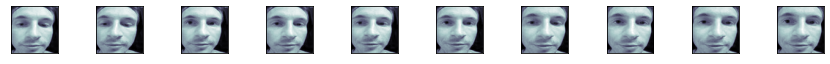

In [23]:
plot_images(markusimages)

In [24]:
pca_markus = perform_pca_on_a_persons_images(markusimages, 5)

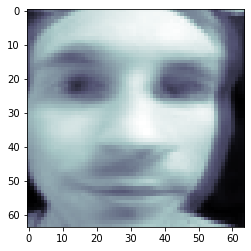

In [25]:
plot_pca_of_image(pca_markus)

Mom

In [2]:
# plot_images(momimages);

In [27]:
# pca_mom = perform_pca_on_a_persons_images(momimages, 5)

In [3]:
# plot_pca_of_image(pca_mom)

Arnie

In [4]:
# plot_images(arnieimages)

In [5]:
# pca_arnie = perform_pca_on_a_persons_images(arnieimages, 5)

In [6]:
# plot_pca_of_image(pca_arnie)

Bryan

In [7]:
# plot_images(bryanimages)

In [8]:
# pca_bryan = perform_pca_on_a_persons_images(bryanimages, 5)

In [9]:
# plot_pca_of_image(pca_bryan)

Becca R

In [10]:
# plot_images(beccarimages)

In [11]:
# pca_beccar = perform_pca_on_a_persons_images(beccarimages, 5)

In [12]:
# plot_pca_of_image(pca_beccar)

Becca D

In [13]:
# plot_images(beccadimages)

In [14]:
# pca_beccad = perform_pca_on_a_persons_images(beccadimages, 5)

In [15]:
# plot_pca_of_image(pca_beccad)

David

In [16]:
# plot_images(davidimages)

In [17]:
# pca_david = perform_pca_on_a_persons_images(davidimages, 5)

In [18]:
# plot_pca_of_image(pca_david)

Whitney

In [19]:
# plot_images(whitneyimages)

In [20]:
# pca_whitney = perform_pca_on_a_persons_images(whitneyimages, 5)

In [21]:
# plot_pca_of_image(pca_whitney)

Aarim

In [22]:
# plot_images(aarimimages)

In [23]:
# pca_aarim = perform_pca_on_a_persons_images(aarimimages, 5)

In [24]:
# plot_pca_of_image(pca_aarim)

Andy

In [25]:
# plot_images(andyimages)

In [26]:
# pca_andy = perform_pca_on_a_persons_images(andyimages, 5)

In [27]:
# plot_pca_of_image(pca_andy)

Chase

In [28]:
# plot_images(chaseimages)

In [29]:
# pca_chase = perform_pca_on_a_persons_images(chaseimages, 5)

In [30]:
# plot_pca_of_image(pca_chase)

In [56]:
combined_images = np.concatenate((markusimages, momimages, arnieimages, bryanimages, 
                                  beccarimages, beccadimages, davidimages, whitneyimages,
                                 aarimimages, andyimages, chaseimages))
combined_images.shape

(110, 4096)

In [57]:
pca_combined = perform_pca_on_a_persons_images(combined_images, 64)

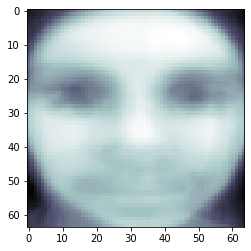

In [58]:
plot_pca_of_image(pca_combined)

In [59]:
pca_data_combined = convert_data_to_pca_data(combined_images, pca_combined)
pca_data_combined.shape

(110, 64)

In [60]:
target_set = make_target_set_for_a_number_of_unique_images(num_of_unique_images) 

The target numbers correspond to people:

0: Markus <br>
1: Mom <br>
2: Arnie <br>
3: Bryan <br>
4: Beccar <br>
5: Beccad <br>
6: David <br>
7: Whitney <br>
8: Aarim <br>
9: Andy <br>
10: Chase <br>

In [61]:
Xtrain, Xtest, Ttrain, Ttest = train_test_split(combined_images, target_set)
Xtrain.shape, Xtest.shape, Ttrain.shape, Ttest.shape

((82, 4096), (28, 4096), (82, 1), (28, 1))

In [62]:
Xtrainpca, Xtestpca, Ttrainpca, Ttestpca = train_test_split(pca_data_combined, target_set)
Xtrainpca.shape, Xtestpca.shape, Ttrainpca.shape, Ttestpca.shape

((82, 64), (28, 64), (82, 1), (28, 1))

Note that I used 2 different splits. One for the PCA-applied data, and one for the original data. This means comparing among PCA vs. non-PCA algorithms is not "pure" (the train and test sets are not *exactly* the same when comparing PCA to non-PCA methods). But if I split and then applied PCA on only the train and test sets, there wasn't enough test data to perform a good PCA. By using sklearn's decomposition PCA, I could only use from 0-28 principal components since the test dataset only had a size of 28 (splitting 75% train/25% test out of 110 pictures). Breaking 4096 down to only ~16 components didn't work very well with the algorithms, but using 64 principal components worked fine. In my opinion this wasn't too big of an issue because it's the same data, but just using 2 different splits of the data. 

Although I did learn a lesson that when doing something like this, one probably wants to make sure they have more data than I had when performing principal component analysis.

Since the main goal of this project was to compare algorithms, I used the same train/test split for the 3 algorithms (SVM, NN, CNN). I could've re-split the data each time I trained an algorithm, but I wanted to keep the data the same for an accurate comparison. I understand I could've partitioned the data into folds like we did in Assignment 4 and performed analyses based off of varying train/test sets, but for comparison reasons I kept the train and test set the same across algorithms and runs when I varied hyperparameters.

# Results

## Support Vector Machine

In [63]:
#the svm performs classification
def perform_svc(X_train, X_test, T_train, T_test, regularization_parameter=5, gamma=0.001):
    clf = svm.SVC(C=regularization_parameter, gamma=gamma)
    clf.fit(X_train, T_train.ravel())
    Y_test = clf.predict(X_test)
    return metrics.accuracy_score(T_test, Y_test)

In [64]:
#averages multiple runs of the above function, if desired
def average_svc(X_train, X_test, T_train, T_test, num_times_for_average, regularization_parameter, gamma):
    accuracy = 0 
    for i in range(num_times_for_average):    
        accuracy += perform_svc(X_train, X_test, T_train, T_test, regularization_parameter, gamma)
    averageAccuracy = (accuracy / num_times_for_average) * 100
    return averageAccuracy, regularization_parameter, gamma

In [65]:
#automation - runs many different hyperparameters and displays a dataframe
def run_averages(X_train, X_test, T_train, T_test, num_times_for_average, average_function, regularization_parameters, gammas):
    results = []
    for rp in regularization_parameters:
        for gamma in gammas:
            results.append(average_function(X_train, X_test, T_train, T_test, num_times_for_average, rp, gamma))
            
    dataframe = pd.DataFrame(results, columns=['Average Accuracy', 'Regularization Parameter', 'Gamma'])
    return dataframe

Performing classification with a support vector machine, with principal component decomposition. Each set of hyperparameters is averaged over 100 runs.

In [66]:
dataframe = run_averages(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 100,
                         average_svc, regularization_parameters=[5,3,1,7,9,11], 
                         gammas=[0.001, 0.0001, 0.00001, 0.01, 0.1])

dataframe.sort_values('Average Accuracy', ascending=False)

,Average Accuracy,Regularization Parameter,Gamma
25,78.571429,11,0.00100
15,75.000000,7,0.00100
28,75.000000,11,0.01000
3,75.000000,5,0.01000
23,75.000000,9,0.01000
20,75.000000,9,0.00100
18,75.000000,7,0.01000
8,75.000000,3,0.01000
13,64.285714,1,0.01000
0,64.285714,5,0.00100


Performing classification with a support vector machine, without principal component decomposition. Each set of hyperparameters is averaged over 100 runs.

In [ ]:
dataframe = run_averages(Xtrain, Xtest, Ttrain, Ttest, 100,
                         average_svc, regularization_parameters=[5,3,1,7,9,11], 
                         gammas=[0.001, 0.0001, 0.00001, 0.01, 0.1])

dataframe.sort_values('Average Accuracy', ascending=False)

Best parameters for support vector machine classification with principal component decomposition: <br>
regularization parameter: 9, 11 (tied) <br>
gamma: 0.001  <br>

Best parameters for support vector machine classification without principal component decomposition: <br>
regularization parameter: 3, 5, 7, 9, 11 (tied) <br>
gamma: 0.001 <br>

85.7% for the highest accuracy, support vector machine classification with principal component decomposition. <br>
100% for the highest accuracy, support vector machine classification without principal component decomposition. <br>

Gamma of 0.001 did the best across PCA and non-PCA data.

See documentation here https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html for explanation of the regularization and gamma hyperparameters.

## Normal Neural Network Classifier

In [ ]:
#the nn performs classification
def perform_neural_network_classification(X_train, X_test, T_train, T_test, hidden_layers, n_epochs=1000, method='sgd', learning_rate=0.05):
    num_input_units = X_train.shape[1]
    num_output_units = len(np.unique(T_train))
    
    nnet = nn.NeuralNetworkClassifier(num_input_units, hidden_layers, num_output_units)
    nnet.train(X_train, T_train, n_epochs, method, learning_rate, verbose=False)
    Y_test = nnet.use(X_test)
    accuracy = percent_correct(Y_test[0], T_test)
    
    return accuracy

In [ ]:
#averages multiple runs of the above function, if desired
def average_nn_classification(X_train, X_test, T_train, T_test, num_times_for_average, hidden_layers, n_epochs, method, learning_rate):
    accuracy = 0 
    for i in range(num_times_for_average):    
        accuracy += perform_neural_network_classification(X_train, X_test, T_train, T_test, hidden_layers, n_epochs, method, learning_rate)
        
    averageAccuracy = accuracy / num_times_for_average
    
    return averageAccuracy, hidden_layers, n_epochs, method, learning_rate

In [ ]:
#automation - runs many different hyperparameters 
def run_averages_for_nn_classification(X_train, X_test, T_train, T_test, num_times_for_average, average_function, list_of_hidden_layers, n_epochs,
                                       methods, learning_rates):
    results = []
    for hidden_layers in list_of_hidden_layers:
        for n_epoch in n_epochs:
            for method in methods:
                for learning_rate in learning_rates:
                    results.append(average_function(X_train, X_test, T_train, T_test, num_times_for_average, 
                                                    hidden_layers, n_epoch,
                                                    method, learning_rate))
            
    dataframe = pd.DataFrame(results, columns=['Average Accuracy', 'Hidden Layers', 'N_epoch',
                                              'Method', 'Learning rate'])
    return dataframe

Performing classification with a normal neural network classifier, with principal component decomposition. Each set of hyperparameters is averaged over 3 runs.

In [ ]:
dataframe = run_averages_for_nn_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 3,
                                               average_nn_classification, list_of_hidden_layers=[[10], [20], [30], [10, 10], [5, 5, 5]], 
                                               n_epochs=[1000, 3000, 5000], methods=['sgd', 'adam'], learning_rates=[0.001, 0.005, 0.01, 0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

Performing classification with a normal neural network classifier, without principal component decomposition. Each set of hyperparameters is averaged over 3 runs.

In [ ]:
dataframe = run_averages_for_nn_classification(Xtrain, Xtest, Ttrain, Ttest, 3,
                                               average_nn_classification, list_of_hidden_layers=[[10], [20], [30], [10, 10], [5, 5, 5]], 
                                               n_epochs=[1000, 3000, 5000], methods=['sgd', 'adam'], learning_rates=[0.001, 0.005, 0.01, 0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

Best parameters for a normal neural network classifier with principal component decomposition: <br>
hidden layer structure: [10] <br>
number of epochs: 3000, 5000 <br>
method: sgd <br>
learning rate: 0.05 <br>

Best parameters for a normal neural network classifier without principal component decomposition: <br>
hidden layer structure: [20], [30] <br>
number of epochs: 1000, 3000 <br>
method: adam <br>
learning rate: 0.001, 0.005 <br>

65.5% for the highest accuracy, support vector machine classification with principal component decomposition. <br>
100% for the highest accuracy, support vector machine classification without principal component decomposition. <br>

SGD did better for PCA-data, while Adam did better for the normal data. Also, single layers with more units did better than multiple layers of smaller units. Higher numbers of epochs performed better on PCA data, but there wasn't a noticeable difference on normal data.

## PyTorch Convolutional Neural Network

There were more hyperparameters to adjust for this PyTorch convolutional neural network implementation than the normal neural network. So instead of running 1 giant run call for PCA data and 1 giant run call for non-PCA data, I broke them up by changing the learning rate and varying the other hyperparameters. This was purely just to try different hyperparameters in a shorter amount of time and see results a little more clearly, rather than having a dataframe with hundreds of entries. 

In [ ]:
#the cnn performs classification
def perform_cnn_torch_classification(X_train, X_test, T_train, T_test, units_per_conv_layer=[10], units_per_normal_layer=[10],
                                     patch_size_per_conv_layer=[4], stride_per_conv_layer=[2],
                                     batch_size=10, n_epochs=1000, method='sgd', learning_rate=0.01):
    
    num_input_units = X_train.shape[1]
    sqrt_num_input_units = int(np.sqrt(num_input_units))
    
    X_train = X_train.reshape(-1, 1, sqrt_num_input_units, sqrt_num_input_units)
    X_test = X_test.reshape(-1, 1, sqrt_num_input_units, sqrt_num_input_units)
    T_train = T_train.flatten()
    T_test = T_test.flatten()
    
    cnnet = cnn.ConvNet(num_input_units, units_per_conv_layer, units_per_normal_layer, len(np.unique(T_train)), 
                        patch_size_per_conv_layer, stride_per_conv_layer, device='cpu') #always running torch cnn on gpu

    cnnet.train(X_train, T_train, batch_size, n_epochs, learning_rate, method, verbose=False)
    
    Y_test_classes, _ = cnnet.use(X_test)
    accuracy = 100 * np.mean(Y_test_classes == T_test)
    
    return accuracy

In [ ]:
#averages multiple runs of the above function, if desired
def average_cnn_torch_classification(X_train, X_test, T_train, T_test, num_times_for_average, 
                                            units_per_conv_layer, units_per_normal_layer, 
                                            patch_size_per_conv_layer, stride_per_conv_layer, 
                                            batch_size, n_epochs, method, learning_rate):
    
    accuracy = 0 
    for i in range(num_times_for_average):    
        accuracy += perform_cnn_torch_classification(X_train, X_test, T_train, T_test,
                                                     units_per_conv_layer, units_per_normal_layer, 
                                                     patch_size_per_conv_layer, stride_per_conv_layer, 
                                                     batch_size, n_epochs, method, learning_rate)
        
    averageAccuracy = accuracy / num_times_for_average
    return averageAccuracy, units_per_conv_layer, units_per_normal_layer, patch_size_per_conv_layer, stride_per_conv_layer, batch_size, n_epochs, method, learning_rate

In [ ]:
#automation - runs many different hyperparameters 
def run_averages_for_cnn_torch_classification(X_train, X_test, T_train, T_test, num_times_for_average, average_function, 
                                              list_units_per_conv_layer, 
                                              list_units_per_normal_layer, list_patch_size_per_conv_layer, 
                                              list_stride_per_conv_layer, batch_sizes, n_epochs, methods, learning_rates):
    results = []
    for hidden_conv_layers in list_units_per_conv_layer:
        for hidden_layers in list_units_per_normal_layer:
            for patch_size in list_patch_size_per_conv_layer:
                for stride in list_stride_per_conv_layer:
                    for batch_size in batch_sizes:
                        for n_epoch in n_epochs:
                            for method in methods:
                                for learning_rate in learning_rates:
                                    results.append(average_function(X_train, X_test, T_train, T_test, num_times_for_average,
                                                                    hidden_conv_layers, hidden_layers, 
                                                                    patch_size, stride, batch_size, n_epoch,
                                                                    method, learning_rate))
                                                           
    dataframe = pd.DataFrame(results, columns=['Average Accuracy', 'Hidden Conv Layers', 'Hidden Layers',
                                               'Patch Size', 'Stride', 'Batch Size', 'N_epoch',
                                               'Method', 'Learning rate'])
    return dataframe

Varying the learning rate and trying it with a lot of different hyperparameters, alternating using PCA and non-PCA data. 

I didn't take an average of these runs like I did for the SVM and NN runs, because these runs were more time-consuming, and I had already found out that these CNNs were going to have higher accuracy than the SVM and vanilla NN runs.

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.001])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.001])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.005])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.005])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.01])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.01])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification,  
                                                      list_units_per_conv_layer=[[10], [30]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2], [4]],
                                                      list_stride_per_conv_layer=[[2], [4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

Now I'm putting in multiple convolutional layers, and corresponding patch and stride sizes for those layers. I would've had to change a lot of logic in my "run_averages_for_cnn_torch_classification" to run multiple-convolutional-layer models at the same time as my single layer convolutional models, so I chose to just use my "run_averages_for_cnn_torch_classification" function again separately.

Varying the learning rate and trying these learning rates with a lot of different hyperparameters.

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.001])
                                
dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.001])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.005])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.005])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.01])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.01])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

In [ ]:
dataframe = run_averages_for_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, 1,
                                                      average_cnn_torch_classification, 
                                                      list_units_per_conv_layer=[[10, 10], [5, 20]], 
                                                      list_units_per_normal_layer=[[10], [30]],
                                                      list_patch_size_per_conv_layer=[[2, 2], [2, 4]],
                                                      list_stride_per_conv_layer=[[2, 2], [2, 4]],
                                                      batch_sizes=[10, 20],
                                                      n_epochs=[100, 500],
                                                      methods=['sgd', 'adam'],
                                                      learning_rates=[0.05])

dataframe.sort_values('Average Accuracy', ascending=False)

Best parameters for this convolutional neural network implementation with principal component decomposition: there were tons of hyperparameter combinations that worked well, so I don't want to enumerate them. In general using multiple convolutional layers was better than just a single convolutional layer, and using the data without PCA resulted in better accuracy.  <br>

Best parameters for this convolutional neural network implementation without principal component decomposition: pretty similar results as above. In general using multiple convolutional layers was better than just a single convolutional layer, and using the data without PCA resulted in better accuracy.  <br>

I also noticed learning rates of 0.001 and 0.005 did better than a learning rate of 0.05 across PCA and non-PCA data.

100% accuracy, convolutional neural network classification with principal component decomposition. <br>
100% accuracy, convolutional neural network classification without principal component decomposition. <br>

## Comparison

A reminder, the target numbers correspond to people: <br>
 <br>
0: Markus <br>
1: Mom <br>
2: Arnie <br>
3: Bryan <br>
4: Beccar <br>
5: Beccad <br>
6: David <br>
7: Whitney <br>
8: Aarim <br>
9: Andy <br>
10: Chase <br>
 <br>
I'll use these target numbers when I look at the confusion matrices to see who got confused with who (if the algorithm made a mistake).

In [ ]:
def compare_svc(X_train, X_test, T_train, T_test, regularization_parameter=5, gamma=0.001):
    start = time.time()

    clf = svm.SVC(C=regularization_parameter, gamma=gamma)
    clf.fit(X_train, T_train.ravel())
    
    end = time.time()

    Y_test = clf.predict(X_test)
    
    print(f"Accuracy is {metrics.accuracy_score(T_test, Y_test) * 100}%, and it took {end-start} seconds.")
    return confusion_matrix(Y_test.reshape(-1,1), T_test)

In [ ]:
def compare_neural_network_classification(X_train, X_test, T_train, T_test, 
                                          hidden_layers, n_epochs=1000, method='sgd', learning_rate=0.05):
    start = time.time()

    num_input_units = X_train.shape[1]
    num_output_units = len(np.unique(T_train))
    
    nnet = nn.NeuralNetworkClassifier(num_input_units, hidden_layers, num_output_units)
    nnet.train(X_train, T_train, n_epochs, method, learning_rate, verbose=False)
    
    end = time.time()

    Y_test = nnet.use(X_test)
    accuracy = percent_correct(Y_test[0], T_test)
    
    print(f"Accuracy is {accuracy}%, and it took {end-start} seconds.")
    return confusion_matrix(Y_test[0], T_test)

In [ ]:
def compare_cnn_torch_classification(X_train, X_test, T_train, T_test, units_per_conv_layer=[10], units_per_normal_layer=[10],
                                     patch_size_per_conv_layer=[4], stride_per_conv_layer=[2],
                                     batch_size=10, n_epochs=1000, method='sgd', learning_rate=0.01):
    start = time.time()

    num_input_units = X_train.shape[1]
    sqrt_num_input_units = int(np.sqrt(num_input_units))
    
    X_train = X_train.reshape(-1, 1, sqrt_num_input_units, sqrt_num_input_units)
    X_test = X_test.reshape(-1, 1, sqrt_num_input_units, sqrt_num_input_units)
    T_train = T_train.flatten()
    T_test = T_test.flatten()
    
    cnnet = cnn.ConvNet(num_input_units, units_per_conv_layer, units_per_normal_layer, len(np.unique(T_train)), 
                        patch_size_per_conv_layer, stride_per_conv_layer, device='cpu') #always running torch cnn on gpu

    cnnet.train(X_train, T_train, batch_size, n_epochs, learning_rate, method, verbose=False)
    
    end = time.time()

    Y_test_classes, _ = cnnet.use(X_test)
    accuracy = 100 * np.mean(Y_test_classes == T_test)
    
    print(f"Accuracy is {accuracy}%, and it took {end-start} seconds.")
    return confusion_matrix(Y_test_classes, T_test)

I used the hyperparameters from the best results from the above runs (for SVM, NN, and CNN) to compare performances below and to look at confusion matrices.

In [ ]:
compare_svc(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, 11, 0.001)

For the above confusion matrix, the network sometimes confused 8 and 5 together, which were Aarim and Beccad. The insight for this would probably be that their faces, with PCA applied, were pretty messy because they had their head turned in different positions for their pictures (see images at the top of this notebook - I don't want to print them out again here because it will clutter this part of the notebook). <br>

Also, the confusion matrix confused 9 with 2, 4, and 5. This means Andy was confused with Arnie, Beccar, and Beccad. I couldn't find too much an explanation for these errors, except possibly that these peoples' eyes were fairly ill-defined in the pictures, so perhaps the SVM messed up because of that. 

In [ ]:
compare_svc(Xtrain, Xtest, Ttrain, Ttest, 11, 0.001)

The SVM worked great here!

In [ ]:
compare_neural_network_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, [10], 3000, 'sgd', 0.05)

For this neural network, 8, 9, and 10 were not matched very well. 8 (Aarim) was confused with Mom and David, probably because of the eyes. Aarim's eyes were ill-defined, just like Mom. David's eyes weren't ill-defined, but they were big, wide, and had large pupils, and so Aarim's PCA'd eyes could've gotten confused with David's eyes. <br>

9 (Andy) was confused with Arnie (like before in the SVM with PCA), and with Whitney. I couldn't find a solid explanation for this. Although it is noteworthy that the PCA features that were picked out during the SVM process were also picked out during the neural network classification process. I can infer this because Andy was confused with Arnie in both the SVM and in the NN algorithms. <br>

Finally, Chase was defined as Aarim every single time for some reason. They aren't very similar, and Aarim's PCA picture was ill-defined while Chase's PCA picture was just fine. The network must've learned something about the PCA'd features and just stayed consistently wrong. 

In [ ]:
compare_neural_network_classification(Xtrain, Xtest, Ttrain, Ttest, [20], 3000, 'adam', 0.001)

The neural network classifier worked great here!

In [ ]:
compare_cnn_torch_classification(Xtrainpca, Xtestpca, Ttrainpca, Ttestpca, [5, 20], [10], [2, 2], [2, 4], 20, 500, 'sgd', 0.05)

The convolutional neural network worked great here!

In [ ]:
compare_cnn_torch_classification(Xtrain, Xtest, Ttrain, Ttest, [5, 20], [10], [2, 2], [2, 4], 20, 500, 'sgd', 0.05)

The convolutional neural network worked great here!

I chose to make a couple of charts comparing run times and accuracy, rather than showing error plots. When I was testing the different hyperparameters for the different algorithms, I made sure to try an exorbitant amount of "number of epochs". I found that the number of epochs is helpful up to a point (for example, 1000 epochs), but after that the networks weren't showing much of an improvement between 1000 epochs and a really high number like 10000 epochs.

So, rather than showing the error decreasing or the accuracy increasing as function of the number of epochs, I chose to plot run times and accuracies for the various algorithms and data they used (PCA or non-PCA).

In [ ]:
x = ['SVM PCA', 'SVM', 'NN PCA', 'NN', 'CNN PCA', 'CNN']
times = [0.001992940902709961, 
          0.02302074432373047, 
          0.8199293613433838, 
          15.740429878234863, 
          2.874938488006592, 
          10.259921550750732]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, times, color='green')
plt.xlabel("Algorithm/Model")
plt.ylabel("Time to Run (in seconds)")
plt.title("Comparing Times To Run Among Various Algorithms/Models")

plt.xticks(x_pos, x)

plt.show()

In [ ]:
x = ['SVM PCA', 'SVM', 'NN PCA', 'NN', 'CNN PCA', 'CNN']
accuracies = [85.714286, 
              100, 
              65.476190, 
              100, 
              100, 
              100]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracies, color='green')
plt.xlabel("Algorithm/Model")
plt.ylabel("Top Accuracies")
plt.title("Comparing Accuracy Among Various Algorithms/Models")

plt.xticks(x_pos, x)

plt.show()

# Conclusions

Rankings (accuracy): <br>
1 PyTorch CNN without PCA, PyTorch CNN with PCA, SVM without PCA, NN classifier without PCA (4-way tie at 100% accuracy)<br>
2 SVM with PCA <br>
3 NN classifier with PCA <br>
4  <br>
5  <br>
6  <br>

Rankings (speed): <br>
1 SVM with PCA <br>
2 SVM without PCA <br>
3 NN classifier with PCA <br>
4 PyTorch CNN with PCA <br>
5 PyTorch CNN without PCA <br>
6 NN classifier without PCA <br>

A couple things didn't go according to plan when starting this project.

At the beginning I couldn't get the SVM to work because I was only trying 2 or 3 different unique faces, and the SVM wasn't working with only 2 or 3 different classes. But as soon as I added more classes (11 people overall) it worked great.

Data-wise, at the beginning of my project I collected data very differently than what I ended up with. I took pictures that included hair, neck, shirt, and I rotated my face and took pictures from different angles. This was not giving me a good "average" face when working with sklearn's PCA, so I decided to standardize all my pictures to be up-close, face only, and barely rotating the head in a ~20 degrees radius. 

The comparison I proposed in my proposal was just to compare accuracy among SVMs, NNs, and CNNs. Although at the time I didn't think about comparing how the algorithms would perform if they faces were rotated, or if people had different clothes on, or if people had different facial expressions. As I mention later, the CNN probably would've outperformed the NN and SVM in these cases, but I just simply didn't think about including a comparison like this at the beginning of the project. 

It was a lot of work cleaning the data. I didn't take the pictures; I asked my friends and family to send the pictures to me after taking the pictures themselves. I made sure the .jpg files were all the same pixel size, and I took the coloring out of the pictures as part of pre-processing the data. The pictures were pretty much standardized, except some people had glasses, different hairstyles, and different facial hair. Some of the people rotated their head, eyes, and facial expression just a little bit.

My results were pretty similar to what I predicted in my project proposal. I predicted a PyTorch implementation of a convolutional neural network classifier, without principal component decomposition on the data, to do the best. This was correct (although other algorithms/models got 100% accuracy also). 

But after that, I predicted a normal neural network classifier as we defined in class to do the best. This was not right, and the support vector machine actually did slightly better than the normal neural network classifier (on PCA data). 

The sklearn SVM algorithm I used took just two hyperparameters: a regularization hyperparameter, and a gamma hyperparameter. There are other hyperparameters I could've tuned, such as the degree and type of kernel, but I just chose these two for this project. Overall I tried out 30 different combinations of hyperparameters for the SVM.

But the neural network classifier I used took 4 hyperparameters: neural network structure (hidden units and layers), number of epochs, method (sgd or adam algorithm), and learning rate. Overall I tried out 120 different combinations of hyperparameters for the normal neural network.

For the PyTorch CNN, I used 8 different hyperparameters: the convolutional layer structure, the fully connected layer structure, the patch size per convolutional layer, the stride per convolutional layer, the batch size, the number of epochs, the method (sgd or adam algorithm), and the learning rate. Overall I tried out 256 different combinations of hyperparameters for the PyTorch CNN.

One major factor when judging an algorithm should be speed. The SVM was by far the fastest algorithm to use with this dataset. I spent multiple days just training and trying to get results out of the neural networks, while the SVM ran almost instantly. I also learned a key lesson while running the PyTorch algorithm as well: not everything is faster when moving over to the GPU. Because I'm working with a fairly small dataset and network structure, moving the data and the model over to the GPU took longer than just running the data on the cpu. (Although I understand GPUs and TPUs are very effective in many ML cases - it just turns out it wasn't as effective for my small data and small models). So I learned this is something to think about when implementing a ML strategy: what is the goal, and how much time is available? This is a loaded question, though, because many networks are pretrained now, like GPT-3. So the speed benefits of a SVM may not be as dramatic as this project proposes, because in reality maybe the network or SVM model just has to be "used", and not trained and then "used".

Another major factor to consider is how much data is available. At the beginning of my project, I only had a couple of pictures of friends and family (2-3), and the SVM was simply not working. I needed to have more data to get reasonable results out of the SVC. But for the neural network and PyTorch CNN, a small amount of data still worked and gave me reasonable results.

I didn't test out the impact of how rotating one's head would affect the results, but that also wasn't what I proposed when I started this project. Now that I'm done with it, I'd be interested to see how rotating one's head would affect the results. My guess after reading a couple academic papers is that a convolutional neural network or a ResNet would work far better than an SVC or NN would in this case.

The confusion matrices didn't misclassify faces by sex or familial structure, but rather simply by what distinctive facial features were common amongst the images. If someone had bushy eyebrows, glasses, or rotated their head, I found the algorithm was more likely to confuse a face with someone else's who also had bushy eyebrows, or who also had rotated their head. Also, the major errors in accuracy were when PCA was applied to the original picture data. 

I learned I didn't really need to apply PCA here. At the beginning of this project I didn't really understand PCA and I just wanted to apply it to data and see what would happen. Now I know PCA is sometimes used when there are a lot of features, and it is used to speed up computations at the cost of accuracy. 

I also learned how important and time consuming data preprocessing is. The orientation of the picture matters, the size of the picture matters, the quantity of data matters, and the number of features in the data matters. I'm sure there are companies that develop preprocessing software for different use cases (whether it's for NLP, computer vision, or other ML purposes). 

Interestingly, the most difficult thing about this project was knowing when to cut if off. I could keep trying different hyperparameters, I could keep trying different algorithms, I could collect more data from different people, I could try averaging speed and accuracy for even more runs, and I could collect different data from people (different expressions, them in a crowd, them rotating their head, them in different outfits, etc.) 

I was a little surprised that many of the models were able to reach 100% accuracy. On one hand, it seems easy to make the models work since I standardized the data the way I did. An obvious answer to make this project more difficult would've been to collect different types of data, and more data. But as I started this project I wasn't even sure I could get the models to classify people correctly. So I think this was a great project to go through the process of collecting the data, processing it, and actually implementing a couple of algorithms/models that could classify faces very accurately. 

Ultimately I had to just cut off how much work I was doing because I could try different hyperparameters all day, and they would give me slightly different results between runs. I had to just get average accuracies and analyze my data from those runs. For a future project idea, I could try another algorithm like a ResNet, and I could collect more (and different) data.

# References

[He, et al., 2015] Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun. Deep Residual Learning for Image Recognition. https://arxiv.org/abs/1512.03385. 2021. <br>

[Minaee, et al., 2021] Shervin Minaee and Ping Luo and Zhe Lin and Kevin Bowyer. Going Deeper Into Face Detection: A Survey. https://arxiv.org/abs/2103.14983. 2021. <br>

[Jolliffe and Cadima, 2016] Ian T. Jolliffe and Jorge Cadima. Principal component analysis: a review and recent developments. The Royal Society Publishing. 2021. <br>

[Varoquaux, 2020] Gael Varoquaux, Scipy Lecture Notes. http://scipy-lectures.org/index.html. 2021. <br>

[Wang and Deng, 2018] Mei Wang and Weihong Deng. Deep Face Recognition: A Survey. https://arxiv.org/abs/1804.06655. 2021. <br>

### Other 

http://scipy-lectures.org/packages/scikit-learn/index.html#introduction-problem-settings (using images/PCA-images in an SVM) <br>

https://towardsdatascience.com/a-complete-guide-to-principal-component-analysis-pca-in-machine-learning-664f34fc3e5a (PCA info) <br>

https://www.baeldung.com/cs/svm-vs-neural-network (differences between SVM and NN algorithms) <br>

https://stats.stackexchange.com/questions/510052/are-neural-networks-better-than-svms (differences between SVM and NN algorithms) <br>

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html (svm.SVC function parameters) <br>

https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer (video on PCA) <br>

https://www.iloveimg.com/ (resizing images) <br>

Code (not standard Python 3rd party libraries) <br>

neuralnetworks.py (from class) <br>
neuralnetworkscnn.py (from class) <br>
optimizers.py (from class) <br>

# Extra Work

Using the "olivetti_faces" dataset from sklearn combined with the data I collected.

In [ ]:
faces = datasets.fetch_olivetti_faces()
faces.data.shape, faces.target.shape

In [ ]:
faces.target += 11

In [ ]:
all_faces = np.concatenate((combined_images, faces.data))
all_faces.shape

In [ ]:
all_targets = np.concatenate((target_set, faces.target.reshape(-1, 1)))
all_targets.shape

In [ ]:
pca_all_faces = perform_pca_on_a_persons_images(all_faces, 144)
pca_data_all_faces = convert_data_to_pca_data(all_faces, pca_all_faces)
pca_data_all_faces.shape

In [ ]:
Xtrain_all_pca, Xtest_all_pca, Ttrain_all_pca, Ttest_all_pca = train_test_split(pca_data_all_faces, all_targets)
Xtrain_all_pca.shape, Xtest_all_pca.shape, Ttrain_all_pca.shape, Ttest_all_pca.shape

In [ ]:
Xtrain_all, Xtest_all, Ttrain_all, Ttest_all = train_test_split(all_faces, all_targets)
Xtrain_all.shape, Xtest_all.shape, Ttrain_all.shape, Ttest_all.shape

In [ ]:
perform_svc(Xtrain_all_pca, Xtest_all_pca, Ttrain_all_pca, Ttest_all_pca, 11, 0.001) #90% accurate

In [ ]:
perform_svc(Xtrain_all, Xtest_all, Ttrain_all, Ttest_all, 11, 0.001) #96.8% accurate

In [ ]:
perform_neural_network_classification(Xtrain_all_pca, Xtest_all_pca, Ttrain_all_pca, Ttest_all_pca, [20], 5000, 'sgd', 0.001)

In [ ]:
perform_neural_network_classification(Xtrain_all, Xtest_all, Ttrain_all, Ttest_all, [20], 5000, 'sgd', 0.001)

In [ ]:
perform_cnn_torch_classification(Xtrain_all_pca, Xtest_all_pca, Ttrain_all_pca, Ttest_all_pca, 
                                 [5, 20], [10], [2, 2], [2, 4], 20, 1000, 'sgd', 0.001)

In [ ]:
perform_cnn_torch_classification(Xtrain_all, Xtest_all, Ttrain_all, Ttest_all, 
                                 [5, 20], [10], [2, 2], [2, 4], 20, 1000, 'sgd', 0.001)

After doing a couple runs, the PyTorch CNN and SVM are working decently, but the plain NN isn't working very well. My guess is because I only have 10 pictures of each class (person), and so the neural network  isn't suited very well for having many classes but only a small amount of data for each class.

Similar explanation for the PyTorch CNN. It did okay, but I don't think it performs well on a dataset with many classes and a small amount of data for each class.

In [ ]:
import io
import nbformat
import glob
nbfile = glob.glob('Dabell-Final_Project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)